In [9]:
import numpy as np
import opendatasets as od
od.download("https://www.kaggle.com/datasets/dextershepherd/non-linear-optical-tactile-data")
datapath_="/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/"
import sys
sys.path.insert(1, '/its/home/drs25/Robot_foot')
from Robot_foot import opticalSensor, ImageDataPreprocessor
from tempfile import mkdtemp
import os
import matplotlib.pyplot as plt
import cv2
from models import *
from sklearn.ensemble import RandomForestClassifier
from data_format import *
import joblib  # For saving and loading the model
from sklearn.metrics import accuracy_score, classification_report

Skipping, found downloaded files in "./non-linear-optical-tactile-data" (use force=True to force download)


## convert data

In [2]:
def load_files_memory_efficient(directory, type_="circle", temp_dir=None):
    if temp_dir is None:
        temp_dir = mkdtemp()
    
    # First pass: collect labels and create mapping
    keys = {}
    file_paths = []
    
    for item in os.listdir(directory):
        full_path = os.path.join(directory, item)
        if not os.path.isfile(full_path):
            continue
            
        filename = os.path.basename(full_path)
        newlabel = filename.split("_")[2]
        
        if newlabel not in keys:
            keys[newlabel] = len(keys)
        file_paths.append(full_path)
    print(file_paths)
    # Initialize memory-mapped arrays for final output
    sample_file = np.load(file_paths[0])
    if type_ == "circle" or type_ == "pressure":
        sample_file = sample_file[:, :, :len(np.arange(10, 100, 10))]
    
    sample_shape = (1 * 2 * len(np.arange(10, 100, 10)), 50, *sample_file.shape[4:])
    
    # Create memory-mapped arrays for data and labels
    data_memmap_path = os.path.join(temp_dir, 'data_memmap.dat')
    label_memmap_path = os.path.join(temp_dir, 'label_memmap.dat')
    
    # Calculate total size needed
    total_samples = 0
    for file_path in file_paths:
        data = np.load(file_path)
        if type_ == "circle" or type_ == "pressure":
            data = data[:, :, :len(np.arange(10, 100, 10))]
        total_samples += data.shape[0] * 2 * len(np.arange(10, 100, 10))
    
    # Initialize memmap files
    data_memmap = np.memmap(data_memmap_path, dtype=np.uint8, mode='w+', 
                           shape=(total_samples, *sample_shape[1:]))
    label_memmap = np.memmap(label_memmap_path, dtype=np.uint8, mode='w+',
                            shape=(total_samples,))
    
    # Second pass: process files one at a time
    current_idx = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        print("Processing:", filename)
        
        data = np.load(file_path).astype(np.uint8)
        newlabel = filename.split("_")[2]
        num = keys[newlabel]
        
        if type_ == "circle" or type_ == "pressure":
            data = data[:, :, :len(np.arange(10, 100, 10))]
        
        data = data.reshape((1 * 2 * len(np.arange(10, 100, 10)), 50, *data.shape[4:]))
        num_samples = data.shape[0]
        
        # Write to memmap
        data_memmap[current_idx:current_idx + num_samples] = data
        label_memmap[current_idx:current_idx + num_samples] = np.ones((num_samples,)) * num
        
        current_idx += num_samples
    
    # Flush changes to disk
    data_memmap.flush()
    label_memmap.flush()
    
    # Reload as regular arrays (or keep as memmap if you prefer)
    final_data = np.array(data_memmap)
    final_labels = np.array(label_memmap)
    
    # Clean up temporary files
    del data_memmap
    del label_memmap
    try:
        os.remove(data_memmap_path)
        os.remove(label_memmap_path)
    except:
        pass
    
    return final_data, final_labels

In [4]:
prcess=ImageDataPreprocessor()
x,y=load_files_memory_efficient("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure","pressure")
Xo_new=prcess.process_data(x)
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/X_nonlinear_pressure1",Xo_new.astype(np.uint8))
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/y_nonlinear_pressure1",y.astype(np.uint8))
"""
prcess=ImageDataPreprocessor()
x,y=load_files_memory_efficient("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/circle/circle","circle")
Xo_new=prcess.process_data(x)
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/X_nonlinear_circle1",Xo_new.astype(np.uint8))
np.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/y_nonlinear_circle1",y.astype(np.uint8))
"""

['/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_Jeans_P100.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_Felt_P80.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_Plastic_P80.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_FoamG_P100.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_LongCarpet_P80.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_Plastic_P60.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pressure_TT_Flat_P80.npy', '/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/pressure/pressure/pr

'\nprcess=ImageDataPreprocessor()\nx,y=load_files_memory_efficient("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/circle/circle","circle")\nXo_new=prcess.process_data(x)\nnp.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/X_nonlinear_circle1",Xo_new.astype(np.uint8))\nnp.savez_compressed("/its/home/drs25/RoboSkin/Code/NewRigExperiments/optical-tactile-dataset-for-textures/y_nonlinear_circle1",y.astype(np.uint8))\n'

## load in data

In [3]:
#test on model
Xo=np.load(datapath_+"X_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
yo=np.load(datapath_+"y_nonlinear_pressure1.npz")['arr_0'].astype(np.uint8)
print("pressure loaded")
Xp=np.load(datapath_+"X_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
yp=np.load(datapath_+"y_nonlinear_circle1.npz")['arr_0'].astype(np.uint8)
print("circle loaded")

tactip = opticalSensor()
print(Xo.shape,yo.shape)

pressure loaded
circle loaded
(666, 50, 110, 120) (666,)


/its/home/drs25/Robot_foot/Robot_foot/__init__.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(model_dir,"mymodel_lst

## retrain with some non linear

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 20 
Image: (110, 120)
Memory needed: 2.21 GB


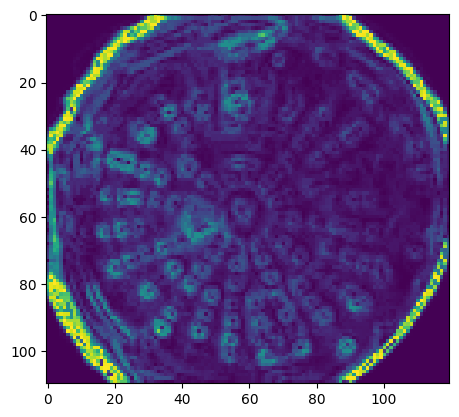

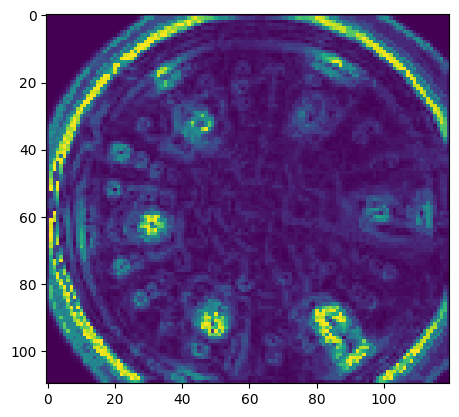

(45000, 20, 110, 120) (666, 20, 110, 120) (666,) (45000,)
(45666, 20, 110, 120) (45666,)


In [16]:
from data_loader import loaded
data=loaded()
data.applySobel()
data.augment()
plt.imshow(data.X[0][0])
plt.show()
plt.imshow(Xo[0][0])
plt.show()
print(data.X.shape,Xo[:,:20].shape,yo.shape,data.y.shape)
data.X=np.concatenate([data.X,Xo[:,:20]])
data.y=np.concatenate([data.y,yo])
print(data.X.shape,data.y.shape)
data.shuffle()

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
frm=0
to=10
n=15000
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
train_loader,test_loader=org_data(data, (len(data.X),abs(frm-to),data.X.shape[2]*data.X.shape[3]),n=n)
model,history=runLSTM(train_loader,0,4,num_epochs=150)
torch.save(model.state_dict(),"/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_lstm_augment")
print(calc(model,test_loader))
print(calc(model,train_loader))


LOADED DATASET...
Memory left 23.59 GB
(15000, 10, 110, 120) (15000, 10, 13200)
Using 14.75 GB
torch.Size([15000, 10, 13200])
torch.Size([15000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)#.to(device)


Epoch [1/150], Step [300/300], Loss: 812.2329
Epoch [11/150], Step [300/300], Loss: 804.4502
Epoch [21/150], Step [300/300], Loss: 602.6724
Epoch [31/150], Step [300/300], Loss: 509.8308
Epoch [41/150], Step [300/300], Loss: 438.8275
Epoch [51/150], Step [300/300], Loss: 395.6830
Epoch [61/150], Step [300/300], Loss: 266.9890
Epoch [71/150], Step [300/300], Loss: 180.7059
Epoch [81/150], Step [300/300], Loss: 126.4804
Epoch [91/150], Step [300/300], Loss: 86.3310
Epoch [101/150], Step [300/300], Loss: 53.2347
Epoch [111/150], Step [300/300], Loss: 28.1256
Epoch [121/150], Step [300/300], Loss: 17.3612
Epoch [131/150], Step [300/300], Loss: 12.0412
Epoch [141/150], Step [300/300], Loss: 9.3447
Finished Training
Accuracy: 98.66337788740375 %
0.9866337788740376
Accuracy: 99.34083882634312 %
0.9934083882634311


## testing time

In [15]:
frm=0
to=4
n=150
data.X=data.X[:n,frm:to]
data.y=data.y[:n,]
Xo_new=(Xo-np.mean(Xo))/(np.max(Xo)-np.min(Xo))
X_data=data.X.reshape((len(data.X),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
model = SimpleLSTM(X_data.shape[2],350,15,3).to(device).to(device)
model.load_state_dict(torch.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/nonlinear_lstm_augment"))
model.eval()
Xo_new=Xo_new.reshape((len(Xo_new),Xo_new.shape[1],-1)).astype(np.float32)
Xo_new=Xo_new[:,0:4,:]
test_array=torch.tensor(Xo_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear circle:",len(acc[acc==True])/len(preds) *100,"%")
test_array=torch.tensor((X_data.astype(np.float32)-np.mean(X_data))/(np.max(X_data)-np.min(X_data))).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==data.y[0:n]
print("Normal dataset:",len(acc[acc==True])/len(preds) *100,"%")

Xp_new=(Xp-np.mean(Xp))/(np.max(Xp)-np.min(Xp))
Xp_new=Xp_new.reshape((len(Xp_new),Xp_new.shape[1],-1)).astype(np.float32)
Xp_new=Xp_new[:,0:4,:]
test_array=torch.tensor(Xp_new[0:n]).to(device)
preds=np.argmax(model(test_array).cpu().detach().numpy(),axis=1)
acc=preds==yo[0:n]
print("Non linear pressure:",len(acc[acc==True])/len(preds) *100,"%")

/tmp/ipykernel_3141141/87840069.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/n

Non linear circle: 24.0 %
Normal dataset: 72.0 %
Non linear pressure: 6.0 %


## random forest classifier??

In [17]:
temp=data.X[:,0:10,:,:].copy()
flattened=temp.reshape((len(temp),-1))
X_train, X_test, y_train, y_test = train_test_split(flattened, data.y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = rfc.predict(X_test)
joblib.dump(rfc, "/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model_nonlinear.pkl")


In [ ]:
rfc = joblib.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/model/random_forest_model.pkl")

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest Classifier:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Xo_reshaped=Xo[:,0:10,:,:].reshape((len(Xo),-1))
y_pred = rfc.predict(Xo_reshaped)
accuracy = accuracy_score(yo, y_pred)
print("Accuracy of Random Forest Classifier on non linear:", accuracy *100,"%")

Xp_reshaped=Xp[:,0:10,:,:].reshape((len(Xp),-1))
y_pred = rfc.predict(Xp_reshaped)
accuracy = accuracy_score(yp, y_pred)
print("Accuracy of Random Forest Classifier on non linear pressure:", accuracy *100,"%")

Accuracy of Random Forest Classifier on non linear: 8.708708708708707 %
Accuracy of Random Forest Classifier on non linear pressure: 7.317073170731707 %


In [6]:
Xo_new=(Xo-np.mean(Xo))/(np.max(Xo)-np.min(Xo))
tactip.model=model
for start,end in zip(range(0,len(Xo)-200,200),range(200,len(Xo),200)):
    correct=0
    preds=tactip.predict_texture_multi(Xo_new[start:end,:10])
    acc=preds==yo[start:end]
    correct+=len(acc[acc==True])

print(correct/len(Xo) *100,"%")

6.456456456456457 %


(1, 2, 10, 50, 480, 640, 3)


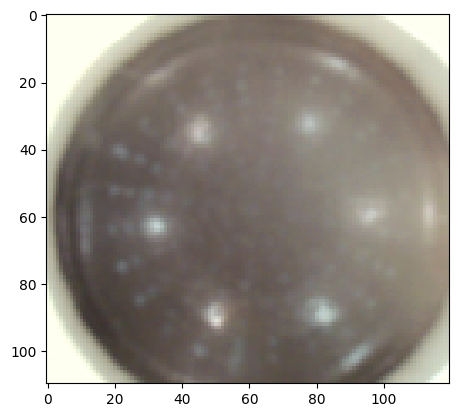

In [ ]:
import cv2
data=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/non-linear-optical-tactile-data/circle/circle/circle_TT_Bubble_P60.npy")
print(data.shape)
crop=[60,180,40,150]
compression_dim=0.4
new_dim=(int(640*compression_dim),int(480*compression_dim))
image=data[0][0][0][0]
image = cv2.resize(image,new_dim,interpolation=cv2.INTER_AREA)
plt.imshow(image[crop[2]:crop[3],crop[0]:crop[1]])
plt.show()